In [1]:
sc

In [2]:
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
import pandas as pd
import json
import numpy as np

In [3]:
def readFile(filename):
    f = open(filename, 'r')
    js = json.loads(f.read())
    f.close()
    return js

# Get total wearing minutes(heart), sleep minutes, steps count data

## No Spark ver.

In [9]:
heart_list = []
sleep_list = []
steps_list = []

users = []
dirs = []

for file in os.listdir("sokulee"):
    dirs.append("sokulee/" + file)
    users.append(file)

for dir in dirs:
    steps = 0
    heart = 0
    sleep = 0
    
    for file in os.listdir(dir):
        if file.endswith("steps.json"):
            try:
                step_js = readFile(dir + "/" + file)
                steps += int(step_js['activities-steps'][0]['value'])
            except:
                pass
                
        if file.endswith("heart.json"):
            try:
                heart_js = readFile(dir + "/" + file)
                heart += int(heart_js['activities-heart'][0]['value']['heartRateZones'][0]["minutes"])
                heart += int(heart_js['activities-heart'][0]['value']['heartRateZones'][1]["minutes"])
                heart += int(heart_js['activities-heart'][0]['value']['heartRateZones'][2]["minutes"])
                heart += int(heart_js['activities-heart'][0]['value']['heartRateZones'][3]["minutes"])
            except:
                pass
                
        if file.endswith("sleep.json"):
            try: 
                sleep_js = readFile(dir + "/" + file)
                sleep += int(sleep_js['summary']['totalMinutesAsleep'])
            except:
                pass
                
    steps_list.append(steps)
    heart_list.append(heart)
    sleep_list.append(sleep)
    
print('heart_list:', heart_list)
print('sleep_list:', sleep_list)
print('steps_list:', steps_list)

heart_list: [57524, 57854, 66945, 57192, 62214, 45397, 62986, 57398, 54681, 32360, 57866, 55362, 35754, 67345, 69617, 5840, 52492, 49228, 69162, 66474, 61600, 66944, 64943, 58326, 38566, 31208, 35154, 66709, 56953, 65818, 64943, 38971, 59812, 43689, 69194, 64064, 39214, 16860, 38367, 67086, 66474, 64064, 65933, 57969, 53690, 67105, 68557, 70112, 65616, 60539, 66944, 68872, 13217, 47166, 63309, 38566, 66267, 36595, 60036, 32360, 54839, 63347, 65125, 60753, 37975, 64497, 65818, 59311]
sleep_list: [19667, 14468, 16604, 17694, 18038, 13576, 14777, 12421, 10518, 8750, 18471, 16994, 9314, 18602, 18638, 6880, 13601, 16302, 18544, 23097, 19536, 18929, 16073, 19270, 10493, 7290, 8578, 18159, 13022, 19038, 16073, 11316, 14696, 12027, 19527, 19146, 11110, 678, 6371, 21080, 23097, 20139, 17990, 16411, 10659, 17510, 19953, 21391, 16215, 21356, 18598, 20921, 2816, 14958, 13319, 10493, 17119, 9153, 18336, 8424, 12472, 22128, 13302, 16262, 3362, 16751, 18642, 13396]
steps_list: [421421, 676258, 107029

In [10]:
fitbit_df = pd.DataFrame({'user':users, 'heart':heart_list, 'sleep':sleep_list, 'steps':steps_list})
fitbit_df.head()

,heart,sleep,steps,user
0,57524,19667,421421,A028
1,57854,14468,676258,A020
2,66945,16604,1070291,A026
3,57192,17694,289223,A053
4,62214,18038,974336,A043


### Top 5 users for each category

In [11]:
fitbit_df.sort_values('heart', ascending=False, inplace=True)
heart_top5 = fitbit_df[:5]

fitbit_df.sort_values('sleep', ascending=False, inplace=True)
sleep_top5 = fitbit_df[:5]

fitbit_df.sort_values('steps', ascending=False, inplace=True)
steps_top5 = fitbit_df[:5]

In [12]:
heart_top5

,heart,sleep,steps,user
47,70112,21391,325833,A049
14,69617,18638,835907,A045
34,69194,19527,584462,A07
18,69162,18544,697669,A017
51,68872,20921,439406,A022


In [13]:
sleep_top5

,heart,sleep,steps,user
40,66474,23097,464660,A027
19,66474,23097,464660,A065
61,63347,22128,413737,A047
47,70112,21391,325833,A049
49,60539,21356,270693,A058


In [14]:
steps_top5

,heart,sleep,steps,user
54,63309,13319,1083320,A025
2,66945,16604,1070291,A026
4,62214,18038,974336,A043
14,69617,18638,835907,A045
44,53690,10659,816567,A062


## Spark ver.

In [15]:
base_path = '/home/datascience/sokulee/'
sokulee_dir = os.listdir(base_path)

users_cols = ['user', 'sleep', 'steps', 'heart']
users_datas = []

for user in sokulee_dir:
    user_dir = base_path + user + '/'
    
    user_df_sleep = spark.read.json(user_dir + '*_sleep.json')
    user_df_steps = spark.read.json(user_dir + '*_steps.json')
    user_df_heart = spark.read.json(user_dir + '*_heart.json')

    sum_of_sleep = user_df_sleep.select(sum(user_df_sleep['summary']['totalMinutesAsleep']))
    sum_of_steps = user_df_steps.select(sum(user_df_steps['activities-steps'][0]['value']))
    sum_of_heart = user_df_heart.select(
                    sum(user_df_heart['activities-heart'][0]['value']['heartRateZones'][0]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][1]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][2]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][3]['minutes']))
    
    users_datas.append([user, sum_of_sleep.head()[0], sum_of_steps.head()[0], sum_of_heart.head()[0]])

In [16]:
fitbit_df = pd.DataFrame(users_datas, columns=users_cols)
fitbit_df.head()

,user,sleep,steps,heart
0,A028,19667,421421.0,57524
1,A020,14468,676258.0,57854
2,A026,16604,1070291.0,66945
3,A053,17694,289223.0,57192
4,A043,18038,974336.0,62214


In [17]:
fitbit_df.sort_values('heart', ascending=False, inplace=True)
heart_top5 = fitbit_df[:5]

fitbit_df.sort_values('sleep', ascending=False, inplace=True)
sleep_top5 = fitbit_df[:5]

fitbit_df.sort_values('steps', ascending=False, inplace=True)
steps_top5 = fitbit_df[:5]

### Top 5 users for each category

In [18]:
heart_top5

,user,sleep,steps,heart
47,A049,21391,325833.0,70112
14,A045,18638,835907.0,69617
34,A07,19527,584462.0,69194
18,A017,18544,697669.0,69162
51,A022,20921,439406.0,68872


In [19]:
sleep_top5

,user,sleep,steps,heart
40,A027,23097,464660.0,66474
19,A065,23097,464660.0,66474
61,A047,22128,413737.0,63347
47,A049,21391,325833.0,70112
49,A058,21356,270693.0,60539


In [20]:
steps_top5

,user,sleep,steps,heart
54,A025,13319,1083320.0,63309
2,A026,16604,1070291.0,66945
4,A043,18038,974336.0,62214
14,A045,18638,835907.0,69617
44,A062,10659,816567.0,53690


# Get mean wearing minutes(heart), sleep minutes, steps count data

## Spark ver.

In [21]:
base_path = '/home/datascience/sokulee/'
sokulee_dir = os.listdir(base_path)

data_cols = ['sleep', 'steps', 'heart']
datas = []

users_cols = ['user', 'sleep', 'steps', 'heart']
users_datas = []

for user in sokulee_dir:
    user_dir = base_path + user + '/'
    
    user_df_sleep = spark.read.json(user_dir + '*_sleep.json')
    user_df_steps = spark.read.json(user_dir + '*_steps.json')
    user_df_heart = spark.read.json(user_dir + '*_heart.json')
    
    mean_of_sleep = user_df_sleep.select(mean(user_df_sleep['summary']['totalMinutesAsleep']))
    mean_of_steps = user_df_steps.select(mean(user_df_steps['activities-steps'][0]['value']))
    mean_of_heart = user_df_heart.select(
                    mean(user_df_heart['activities-heart'][0]['value']['heartRateZones'][0]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][1]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][2]['minutes'] +
                         user_df_heart['activities-heart'][0]['value']['heartRateZones'][3]['minutes']))

    datas.append([mean_of_sleep.head()[0], mean_of_steps.head()[0], mean_of_heart.head()[0]])
    users_datas.append([user, mean_of_sleep.head()[0], mean_of_steps.head()[0], mean_of_heart.head()[0]])

## Set data format for K-means API in Spark

In [22]:
data_df = pd.DataFrame(datas, columns=data_cols).round(2)
user_df = pd.DataFrame(users_datas, columns=users_cols).round(2)

data_df['sleep'] = data_df['sleep'].map('1:{:.2f}'.format)
data_df['steps'] = data_df['steps'].map('2:{:.2f}'.format)
data_df['heart'] = data_df['heart'].map('3:{:.2f}'.format)
data_df.head()

,sleep,steps,heart
0,1:401.37,2:8428.42,3:1173.96
1,1:295.27,2:13525.16,3:1157.08
2,1:338.86,2:21405.82,3:1338.90
3,1:353.88,2:5784.46,3:1243.30
4,1:360.76,2:19486.72,3:1244.28


In [23]:
data_df.to_csv('average.txt', sep=' ', header=False)

In [24]:
dataset = spark.read.format("libsvm").load('average.txt')

## K-means clustering

In [25]:
# Trains a k-means model.
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(dataset)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 101814925.04623917
Cluster Centers: 
[  295.61096774  6993.49935484  1150.06193548]
[   324.866  15007.116   1245.336]
[   309.04315789  10822.96105263   1189.34947368]
[   323.81333333  20852.98         1291.73333333]


In [27]:
user_A08_row = np.array(user_df.iloc[50])
user_A08 = user_A08_row[1:4]
user_A08

array([379.55000000000001, 12586.9, 1338.8800000000001], dtype=object)

## Euclidean distance for A08 User's nearest cluster.

In [28]:
import math

def euclidean_distance(a, b):    
    return math.sqrt( (a[0] - b[0])**2 + 
                      (a[1] - b[1])**2 + 
                      (a[2] - b[2])**2  )

def norm_euclidean_distance(a, b):
    return 1 / (euclidean_distance(a, b) + 1)

In [29]:
norm_dist = -1
users_cluster = []

for center in centers:
    dist = norm_euclidean_distance(center, user_A08)
    if norm_dist < dist:
        norm_dist = dist
        users_cluster = center
    
print("A08's nearest cluster is ", users_cluster)

A08's nearest cluster is  [   309.04315789  10822.96105263   1189.34947368]


## Euclidean distance for A08 User's nearest user.

In [30]:
def euclidean_distance(a, b):    
    return math.sqrt( (a['sleep'] - b['sleep'])**2 + 
                      (a['steps'] - b['steps'])**2 + 
                      (a['heart'] - b['heart'])**2  )

def norm_euclidean_distance(a, b):
    return 1 / (euclidean_distance(a, b) + 1)

In [36]:
user_A08 = pd.Series(['A08', user_A08[0], user_A08[1], user_A08[2]], index = ['user', 'sleep', 'steps', 'heart'])

In [37]:
normoalized_dist = -1
nearest_user = 'A00'
for index, row in user_df.iterrows():
    if row['user'] == 'A08':
        continue

    dist = norm_euclidean_distance(user_A08, row)
    if normoalized_dist < dist:
        normoalized_dist = dist
        nearest_user = row['user']

print("A08's nearest user is %s, normalized_dist = %.10f" %(nearest_user, normoalized_dist))

A08's nearest user is A052, normalized_dist = 0.0051556374


## Visualize user's data and cluster centers

In [38]:
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
import random

In [43]:
centers = np.array(centers)
c_df = pd.DataFrame(centers)
c_df

,0,1,2
0,295.610968,6993.499355,1150.061935
1,324.866000,15007.116000,1245.336000
2,309.043158,10822.961053,1189.349474
3,323.813333,20852.980000,1291.733333


In [52]:
fig3d = pylab.figure()
ax = Axes3D(fig3d)

## User : blue, Cluster center : red

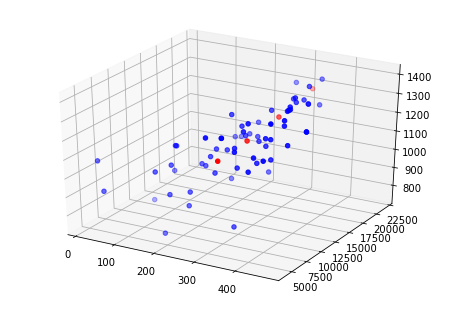

In [53]:
ax.scatter(user_df['sleep'], user_df['steps'], user_df['heart'], color='blue')
ax.scatter(c_df[0], c_df[1], c_df[2], color='red')
pyplot.show()